<a href="https://colab.research.google.com/github/ZavalaCatalina/InteligenciaComputacional/blob/main/BestSellingBooks(2023_2025)_EDA_and_Preprocessing_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Best Selling Books (2023-2025) - EDA and Preprocessing Pipelines

#Descripción

Fuente: https://www.kaggle.com/datasets/malaklahyani/best-selling-books-20232025

Descripción: Este dataset contiene tres periodos de libros más vendidos: 2023, 2024 y 2025. Fue recopilado  de los rankings de Amazon Best Sellers y se utiliza para estudiar tendencias de popularidad, recurrencia de autores y dominancia de categorías.

Problema a resolver: Realizar una Regresión para predecir el Precio (Price) de los libros. Para entender qué características (como el rating o el género) influyen más en el costo de los libros más populares en el mercado actual.

#Importación de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

#Carga de datos y limpieza

In [2]:
import pandas as pd
from google.colab import drive

# Ruta del archivo
path = "/content/drive/MyDrive/Inteligencia Computacional/best sellin books total.csv"

# Cargar del dataset
df = pd.read_csv(path, encoding='latin1')

# Eliminar $ y convertir a decimal (usando r'' para evitar SyntaxWarning)
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)
# Extraer solo el número del rating
df['Rating'] = df['Rating'].str.extract(r'(\d+\.\d+)').astype(float)
# Convertir el conteo de reviews a número
df['reviews count'] = pd.to_numeric(df['reviews count'], errors='coerce')

# Eliminar filas donde el precio sea nulo para no afectar el entrenamiento
df = df.dropna(subset=['price'])

print("Dataset cargado y limpio.")
display(df.head(3))

Dataset cargado y limpio.


,Book name,Author,Rating,reviews count,form,price,Reading age,Print Length,Publishing date,Genre,id_2023,id_2024,id_2025
0,Atomic Habits: An Easy & Proven Way to Build G...,James Clear,4.8,145747,Hardcover,18.88,NaN,320.0,16/10/2018,Self-Improvement,#1,#3,#6
1,"Iron Flame (Standard Edition) (The Empyrean, 2)",Rebecca Yarros,4.7,395512,Hardcover,11.05,NaN,640.0,07/11/2023,Fiction & Action & Adventure,#2,#13,NaN
2,Spare,Prince Harry The Duke of Sussex,4.5,116101,Hardcover,11.99,NaN,416.0,"January 10, 2023",Biographies & Memoirs,#3,NaN,NaN


#Análisis Exploratorio (EDA)
Analizar la distribución de la variable objetivo (price) y revisamos la calidad de los datos para identificar nulos y relaciones entre categorías.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Book name        210 non-null    object 
 1   Author           210 non-null    object 
 2   Rating           210 non-null    float64
 3   reviews count    210 non-null    int64  
 4   form             210 non-null    object 
 5   price            210 non-null    float64
 6   Reading age      71 non-null     object 
 7   Print Length     208 non-null    float64
 8   Publishing date  210 non-null    object 
 9   Genre            210 non-null    object 
 10  id_2023          100 non-null    object 
 11  id_2024          110 non-null    object 
 12  id_2025          98 non-null     object 
dtypes: float64(3), int64(1), object(9)
memory usage: 21.5+ KB
None

Nulos por columna relevante:
Rating           0
reviews count    0
form             0
Genre            0
dtype: int64


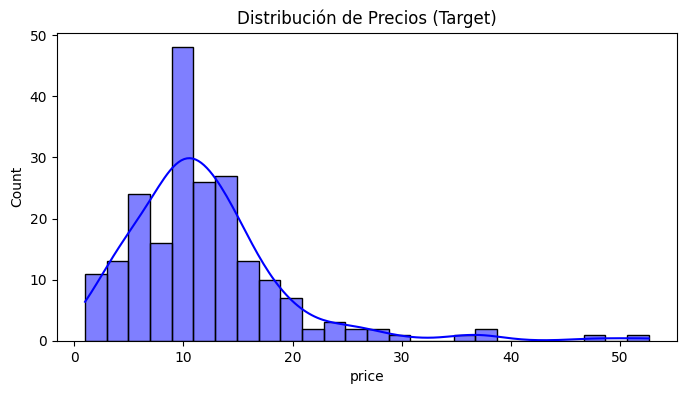

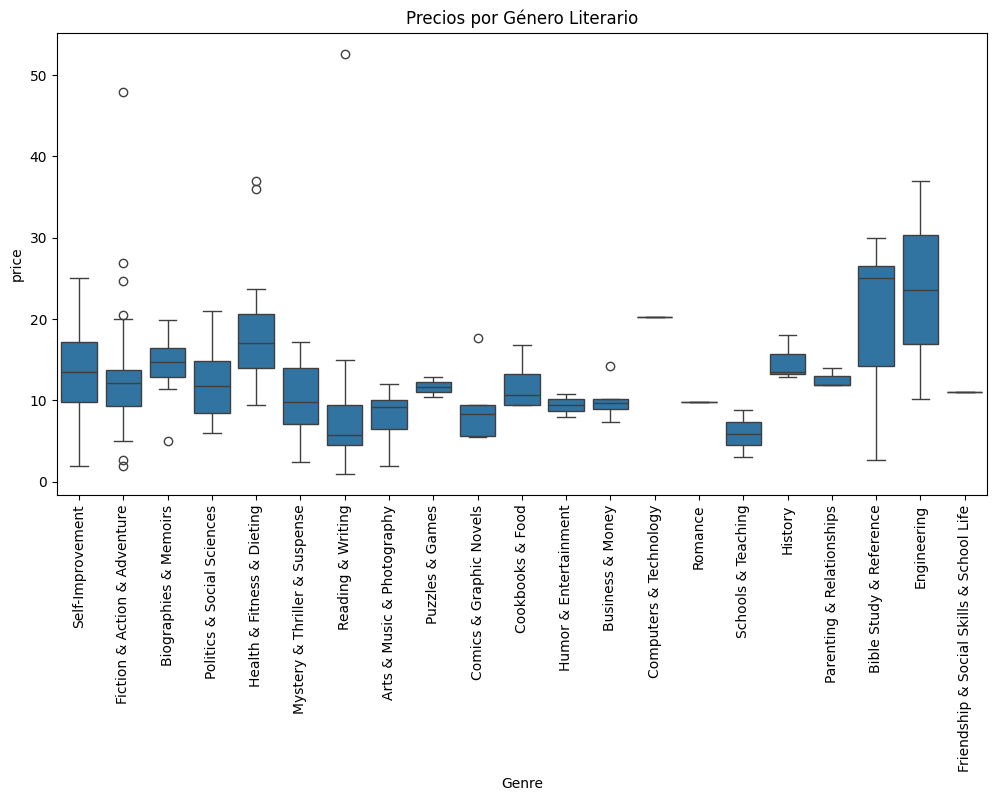

In [3]:
# 1. Información general
print(df.info())

# 2. Conteo de nulos
print("\nNulos por columna relevante:")
print(df[['Rating', 'reviews count', 'form', 'Genre']].isnull().sum())

# 3. Visualización de la Variable Objetivo
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], kde=True, color='blue')
plt.title('Distribución de Precios (Target)')
plt.show()

# 4. Boxplot por Género (Solo los principales para legibilidad)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='price', data=df)
plt.xticks(rotation=90)
plt.title('Precios por Género Literario')
plt.show()

#Estructura Pipeline
Siguiendo el ejemplo dado por el profesor, separamos las variables en numéricas y categóricas.

ColumnTransformer para aplicar diferentes transformaciones: StandardScaler y PowerTransformer para números, y OneHotEncoder para categorías.

Se utiliza un Pipeline para integrar el preprocesamiento y el modelo, evitando así el Data Leakage al asegurar que las transformaciones se calculen solo con los datos de entrenamiento y se apliquen a los de prueba

In [4]:
# Definición de variables
target = 'price'
numeric_features = ['Rating', 'reviews count']
categorical_features = ['form', 'Genre']

X = df[numeric_features + categorical_features]
y = df[target]

# Pipeline para datos numéricos
# Se usa PowerTransformer para manejar el sesgo en el conteo de reviews
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer()),
    ('scaler', StandardScaler())
])

# Pipeline para datos categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinación en ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline Final (Preprocesamiento + Estimador)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

#Entrenamiento y Resultados

Dividimos el dataset en conjuntos de entrenamiento (80%) y prueba (20%) para validar que el modelo pueda generalizar con datos nuevos.

In [5]:
# Partición de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste del modelo completo (Pipeline)
model_pipeline.fit(X_train, y_train)

# Evaluación con métrica R^2 (Coeficiente de determinación)
r2_score = model_pipeline.score(X_test, y_test)
print(f"Puntaje de precisión R^2: {r2_score:.4f}")

# Muestra de predicciones vs valores reales
y_pred = model_pipeline.predict(X_test)
resultados = pd.DataFrame({'Precio Real': y_test, 'Precio Predicho': y_pred})
print("\nComparativa de las primeras 5 predicciones:")
print(resultados.head())

Puntaje de precisión R^2: -0.1827

Comparativa de las primeras 5 predicciones:
     Precio Real  Precio Predicho
30         10.83          13.5622
172         9.99           4.3716
84         13.43          14.9782
199        37.00          15.5813
60          9.74           8.5350


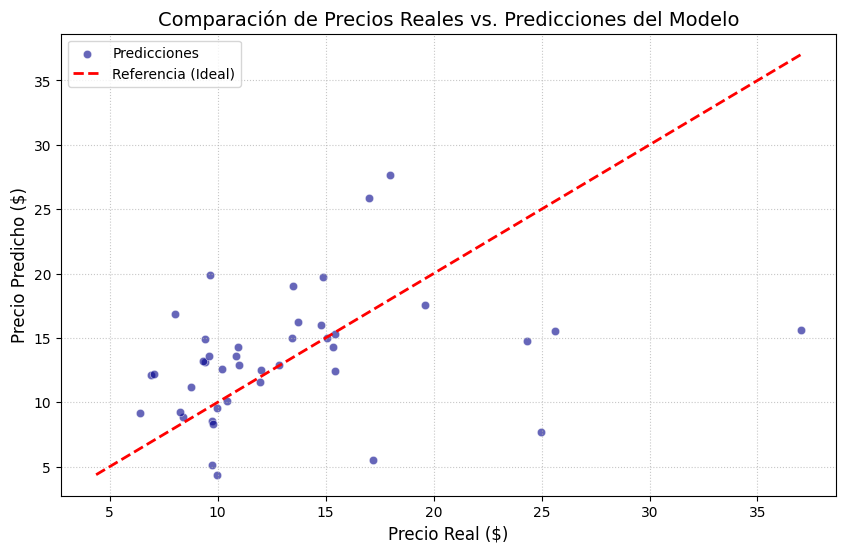

In [6]:
# Configuración de la gráfica
plt.figure(figsize=(10, 6))

# Gráfica de dispersión
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='darkblue', label='Predicciones')

# Línea de referencia (lo que sería una predicción perfecta)
# Corregimos 'lwd' por 'linewidth'
line_coords = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Referencia (Ideal)')

plt.title('Comparación de Precios Reales vs. Predicciones del Modelo', fontsize=14)
plt.xlabel('Precio Real ($)', fontsize=12)
plt.ylabel('Precio Predicho ($)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

#Conclusiones
Con este ejercicio se logró implementar un Pipeline  que procesa datos crudos directamente.

*   El uso de OneHotEncoder permitió incluir el Género y el Formato como factores predictivos del precio. StandardScaler a las numéricas para normalizar las escalas de los dato
*   El modelo nos da una aproximación del valor de mercado de los Best Sellers basándose en su popularidad.

Respecto al analisis de los datos, la mayoría de los Best Sellers se mantienen en el rango de $10 a $25 USD, el formato Paperback suele ser el más común y barato, mientras que Hardcover y Spiral-bound (espiral) suelen marcar los precios más altos del dataset. y La columna reviews count suele tener un sesgo muy fuerte (muchos libros con pocas reseñas y unos pocos con cientos de miles).


